## Breif Look at the Dataset

In [2]:
import pandas as pd
titanic_data = pd.read_csv("train.csv")

In [3]:
titanic_data.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Vande Walle, Mr. Nestor Cyriel",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


* Note: We can see right away that the data set contains 891 passangers; however, only **714** of these passangers have their age logged, **204** have their cabin number logged, and **889** have where they embarked on.

* Note: It will most likely benefit us if we convert the categorical data into numerical data. This way, we can properly visualize all of the data. I must an assumption about the categorical data, however.
  - My first assumption will be that the Titles and last name of each passanger is the only thing that matters in the name (Mr. Mrs. Miss. Master). I believe I can acheive a numerical representation by hashing the last name and title of each individual and adding them together.

* categorical data :
  - Name
  - Sex ("male" : "female" )
  - 

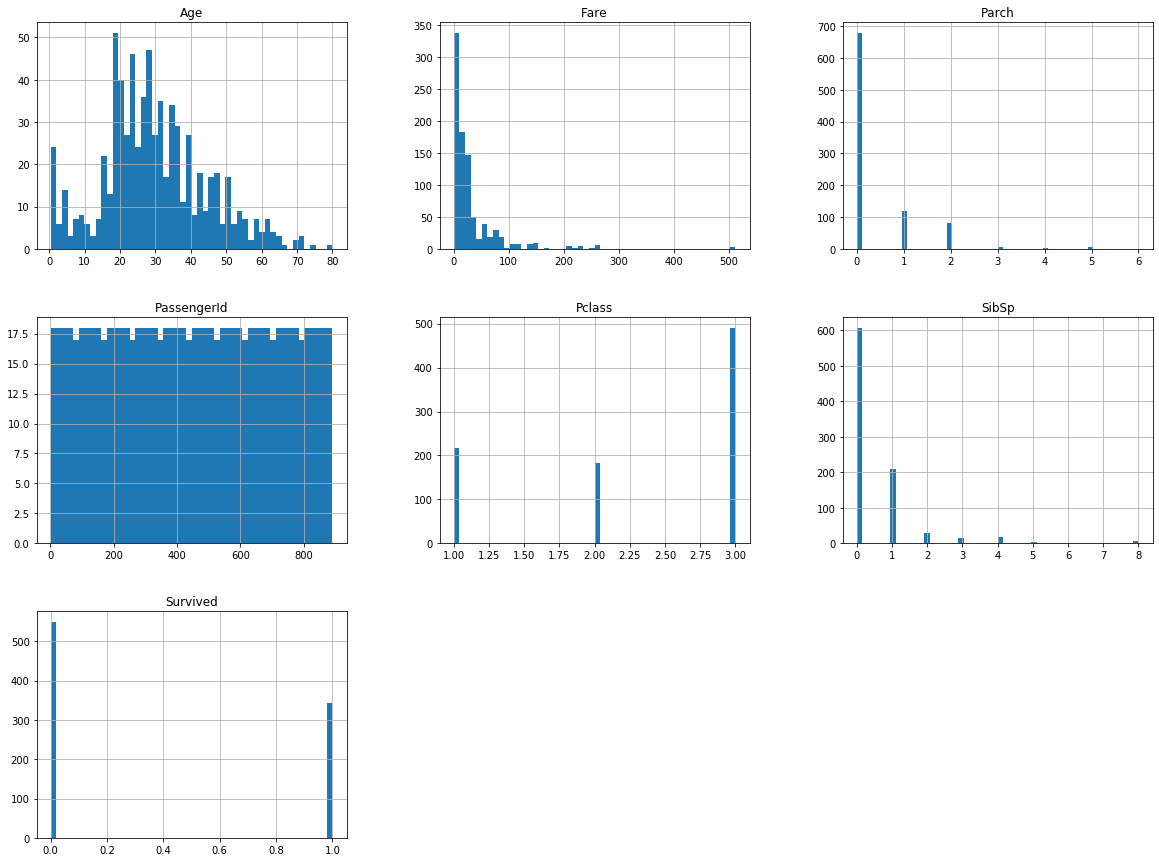

In [4]:
import matplotlib.pyplot as plt
titanic_data.hist(bins=50,figsize=(20,15))
plt.show()

* Note: The ranges for these features vary pretty heavily (Age : [0,80] , PassengerId : [0,800]). We can obviously benefit from some form of **feature scaling**.

## Discover Correlations

In [5]:
corr_matrix = titanic_data.corr()

In [9]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64